# Adversarial starts below

In [1]:
import tensorflow as tf
from tensorflow import keras
from keras.layers import *
import numpy as np 
import time 
import scipy
from keras import Sequential
from keras import Model

num_classes = 1000
input_shape = (28, 28, 3)

(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()

x_train = x_train.astype("float32") / 255
x_test = x_test.astype("float32") / 255
X_train = np.stack([x_train, x_train, x_train], axis=-1)
X_test = np.stack([x_test, x_test, x_test], axis=-1)
Y_train = keras.utils.to_categorical(y_train,1000)
Y_test = keras.utils.to_categorical(y_test,1000)

11501568/11490434 [==============================] - 0s 0us/step


In [2]:
input_mask = np.pad(np.zeros([1, 28, 28, 3]),
                            [[0,0], [98, 98], [98, 98], [0,0]],
                            'constant', constant_values = 1)
input_mask.shape

(1, 224, 224, 3)

In [3]:
%matplotlib inline

(224, 224, 3)


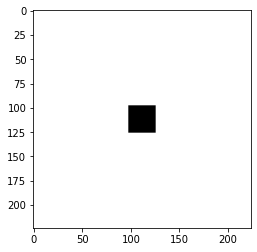

In [4]:
from matplotlib.pyplot import imshow
print(input_mask[0].shape)
imshow(input_mask[0])

In [5]:
import keras.backend as K
config = tf.compat.v1.ConfigProto( device_count = {'GPU': 1 , 'CPU': 2} ) 
sess = tf.compat.v1.Session(config=config) 
K.set_session(sess)
from keras import initializers,regularizers
from keras.optimizers import *
from keras.callbacks import *

M = np.ones((224,224,3)).astype('float32')
M[98:126,98:126,:] = 0

class AdvLayer(Layer):
    def __init__(self, W_regularizer=0.05, **kwargs):
        self.init = initializers.get('glorot_uniform')
        self.W_regularizer = regularizers.l2(W_regularizer)
        super(AdvLayer, self).__init__(**kwargs)
    def build(self, input_shape):
        assert len(input_shape) == 4
        self.W = self.add_weight(name='kernel', 
                                      shape=(224,224,3),
                                      initializer=self.init, regularizer=self.W_regularizer,
                                      trainable=True)
        super(AdvLayer, self).build(input_shape)
    def call(self, x):
        prog = K.tanh(self.W*M)
        out = x + prog
        return out
    def compute_output_shape(self, input_shape):
        return (input_shape[0],input_shape[1],input_shape[2],input_shape[3])

In [6]:
basemodel = tf.keras.applications.ResNet50V2(weights="imagenet")
x = Input(shape=input_shape)
x_aug = ZeroPadding2D(padding=((98,98),(98,98)))(x)
out = AdvLayer()(x_aug)
probs = basemodel(out)
model = Model(inputs=x,outputs=probs)
model.layers[-1].trainable = False
model.summary()

102883328/102869336 [==============================] - 2s 0us/step
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 28, 28, 3)]       0         
                                                                 
 zero_padding2d (ZeroPadding  (None, 224, 224, 3)      0         
 2D)                                                             
                                                                 
 adv_layer (AdvLayer)        (None, 224, 224, 3)       150528    
                                                                 
 resnet50v2 (Functional)     (None, 1000)              25613800  
                                                                 
Total params: 25,764,328
Trainable params: 150,528
Non-trainable params: 25,613,800
_________________________________________________________________


In [ ]:
model.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])
checkpoint = tf.keras.callbacks.ModelCheckpoint("advweights.h5",save_freq='epoch', save_best_only = True, monitor='loss',
                            save_weights_only=True, mode='min', verbose=0)
reduce_lr = keras.callbacks.ReduceLROnPlateau(monitor='loss', factor=0.3, patience=2, min_lr=0.000001, mode='auto')
stopping = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3, mode= 'min')
history = model.fit(X_train,Y_train,epochs = 10,batch_size=16, validation_data = (X_test,Y_test),verbose=1, callbacks=[checkpoint,reduce_lr,stopping])

In [7]:
for layer in model.layers:
    print(layer.name)

input_2
zero_padding2d
adv_layer
resnet50v2


In [9]:
model.add_weight('/content/drive/MyDrive/cs663 weights/advweights_Resnet50.h5')

<tf.Variable '/content/drive/MyDrive/cs663 weights/advweights_Resnet50.h5:0' shape=() dtype=float32, numpy=-0.96901464>

In [8]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [10]:
from keras.models import Model
import tensorflow as tf

layer_name = 'adv_layer'
intermediate_layer_model = Model(inputs=model.get_layer('input_2').output,
                                 outputs=model.get_layer(layer_name).output)
intermediate_layer_model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 28, 28, 3)]       0         
                                                                 
 zero_padding2d (ZeroPadding  (None, 224, 224, 3)      0         
 2D)                                                             
                                                                 
 adv_layer (AdvLayer)        (None, 224, 224, 3)       150528    
                                                                 
Total params: 150,528
Trainable params: 150,528
Non-trainable params: 0
_________________________________________________________________


In [12]:
intermediate_output = intermediate_layer_model.predict(tf.expand_dims(X_test[0],axis=0))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


-0.0108626615
inf
inf


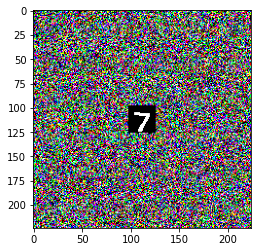

In [35]:
img = tf.math.atanh(intermediate_output[0])
imshow(img*255)

In [43]:
model.add_weight('/content/drive/MyDrive/cs663 weights/advweights_Resnet50.h5')
out = model.predict(tf.expand_dims(X_test[10],axis=0))
np.argmax(out[0])

681